[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


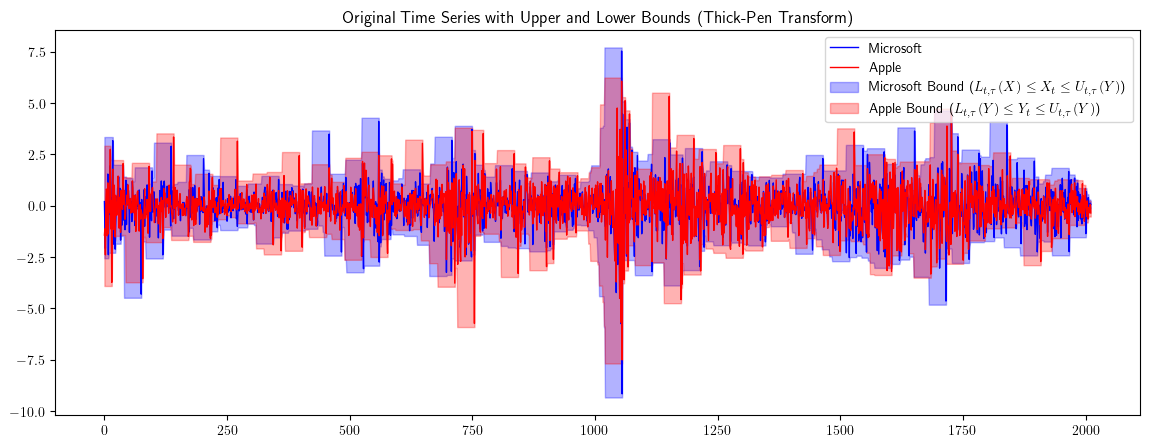

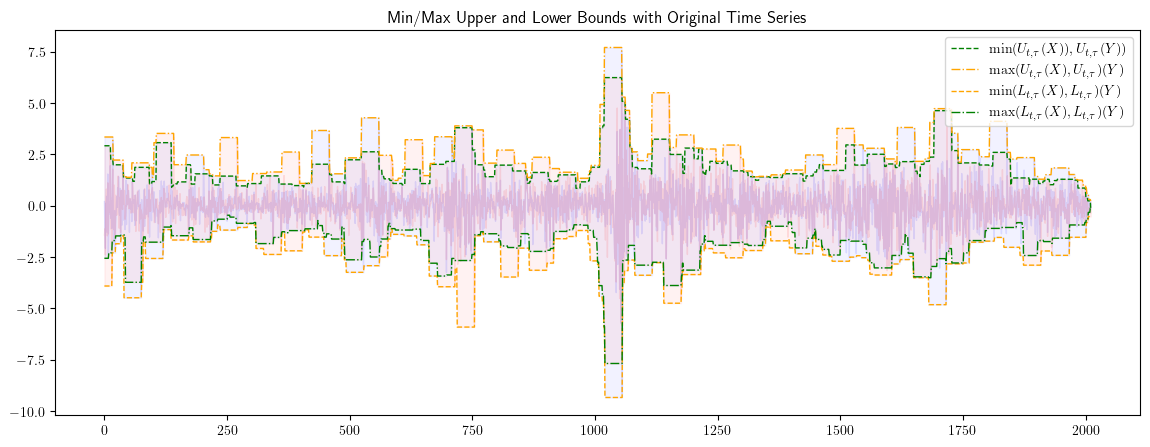

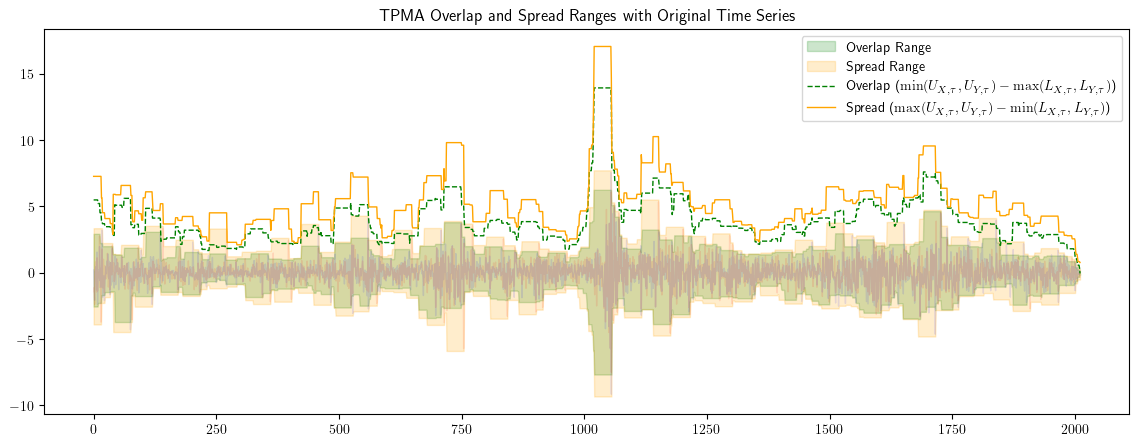

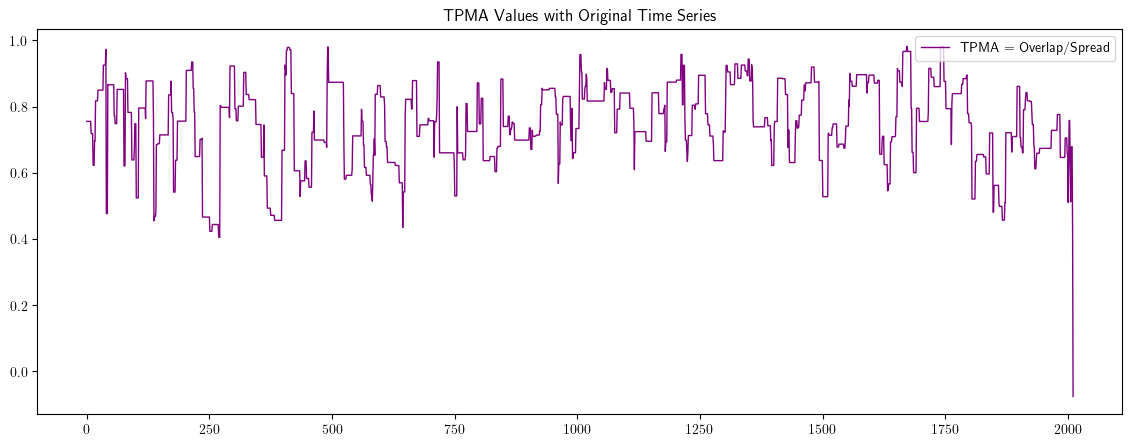

In [27]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# 데이터 크롤링 (최근 8년)
start_date = '2016-01-01'
end_date = '2024-01-01'
microsoft = yf.download('MSFT', start=start_date, end=end_date)
apple = yf.download('AAPL', start=start_date, end=end_date)

# 로그 변환 및 차분
log_microsoft = np.log(microsoft['Close'])
log_apple = np.log(apple['Close'])
diff_log_microsoft = log_microsoft.diff().dropna()
diff_log_apple = log_apple.diff().dropna()

# 표준화 함수
def standardize(series):
    return (series - series.mean()) / series.std()

# 차분 데이터 표준화
std_diff_log_microsoft = standardize(diff_log_microsoft)
std_diff_log_apple = standardize(diff_log_apple)

# 두꺼운펜변환 함수 (사각펜)
def thick_pen_transform(X, tau, gamma=0.01):
    n = len(X)
    U_tau = np.zeros(n)
    L_tau = np.zeros(n)
    
    for t in range(n - tau):
        U_tau[t] = np.max(X[t:t+tau+1]) + gamma * (tau / 2)
        L_tau[t] = np.min(X[t:t+tau+1]) - gamma * (tau / 2)
    
    # 경계 케이스 처리
    for t in range(n - tau, n):
        U_tau[t] = np.max(X[t:n]) + gamma * (tau / 2)
        L_tau[t] = np.min(X[t:n]) - gamma * (tau / 2)
    
    return L_tau, U_tau

tau = 35  # 두께 파라미터 설정
X = std_diff_log_microsoft.values
Y = std_diff_log_apple.values

X_L_tau, X_U_tau = thick_pen_transform(X, tau)
Y_L_tau, Y_U_tau = thick_pen_transform(Y, tau)

# Upper와 Lower 각각 시각화 함수
def plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(X, label=r'Microsoft', color='blue', linewidth=1)
    plt.plot(Y, label=r'Apple', color='red', linewidth=1)
    
    plt.fill_between(range(len(X)), X_L_tau, X_U_tau, color='blue', alpha=0.3, label=r'Microsoft Bound ($L_{{t,\tau}}(X) \leq X_t \leq U_{{t,\tau}}(Y)$)')
    plt.fill_between(range(len(Y)), Y_L_tau, Y_U_tau, color='red', alpha=0.3, label=r'Apple Bound ($L_{{t,\tau}}(Y) \leq Y_t \leq U_{{t,\tau}}(Y)$)')
    
    plt.legend(loc='upper right')
    plt.title('Original Time Series with Upper and Lower Bounds (Thick-Pen Transform)')
    plt.show()

# 시각화
plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, tau)

# min(U,U), max(U,U), min(L,L), max(L,L) 시각화 함수
def plot_min_max_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(X, color='blue', linewidth=1, alpha=0.1)
    plt.plot(Y, color='red', linewidth=1, alpha=0.1)
    
    min_U = np.minimum(X_U_tau, Y_U_tau)
    max_U = np.maximum(X_U_tau, Y_U_tau)
    min_L = np.minimum(X_L_tau, Y_L_tau)
    max_L = np.maximum(X_L_tau, Y_L_tau)
    
    # 오버랩되는 부분을 음영 처리
    plt.fill_between(range(len(X)), X_L_tau, X_U_tau, color='blue', alpha=0.05)
    plt.fill_between(range(len(Y)), Y_L_tau, Y_U_tau, color='red', alpha=0.05)
    
    plt.plot(min_U, color='green', linestyle='--', linewidth=1, label=r'$\min(U_{t,\tau}(X)), U_{t,\tau}(Y))$')
    plt.plot(max_U, color='orange', linestyle='-.', linewidth=1, label=r'$\max(U_{t,\tau}(X), U_{t,\tau})(Y)$')
    plt.plot(min_L, color='orange', linestyle='--', linewidth=1, label=r'$\min(L_{t,\tau}(X), L_{t,\tau})(Y)$')
    plt.plot(max_L, color='green', linestyle='-.', linewidth=1, label=r'$\max(L_{t,\tau}(X), L_{t,\tau})(Y)$')
    
    plt.legend(loc='upper right')
    plt.title('Min/Max Upper and Lower Bounds with Original Time Series')
    plt.show()

# 시각화
plot_min_max_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, tau)

# TPMA의 분자와 분모 각각 시각화 함수
def plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, tau):
    plt.figure(figsize=(14, 5))
    
    overlap_range = [min(X_U_tau[t], Y_U_tau[t]) - max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    spread_range = [max(X_U_tau[t], Y_U_tau[t]) - min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    
    plt.plot(X, color='blue', linewidth=1, alpha=0.1)
    plt.plot(Y, color='red', linewidth=1, alpha=0.1)
    
    # 분자와 분모에 해당하는 음영 추가
    plt.fill_between(range(len(X)), [max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))], [min(X_U_tau[t], Y_U_tau[t]) for t in range(len(X))], color='green', alpha=0.2, label='Overlap Range')
    plt.fill_between(range(len(X)), [min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))], [max(X_U_tau[t], Y_U_tau[t]) for t in range(len(X))], color='orange', alpha=0.2, label='Spread Range')
    
    plt.plot(overlap_range, color='green', linestyle='--', linewidth=1, label='Overlap ($\\min(U_{X,\\tau}, U_{Y,\\tau}) - \\max(L_{X,\\tau}, L_{Y,\\tau})$)')
    plt.plot(spread_range, color='orange', linestyle='-', linewidth=1, label='Spread ($\\max(U_{X,\\tau}, U_{Y,\\tau}) - \\min(L_{X,\\tau}, L_{Y,\\tau})$)')
    
    plt.legend(loc='upper right')
    plt.title('TPMA Overlap and Spread Ranges with Original Time Series')
    plt.show()

# 시각화
plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, tau)

# 두꺼운펜 변환 상관계수 계산 함수
def rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau):
    rho_tau_t = np.zeros(len(X))
    
    for t in range(len(X)):
        min_U = min(X_U_tau[t], Y_U_tau[t])
        max_L = max(X_L_tau[t], Y_L_tau[t])
        max_U = max(X_U_tau[t], Y_U_tau[t])
        min_L = min(X_L_tau[t], Y_L_tau[t])
        
        rho_tau_t[t] = (min_U - max_L) / (max_U - min_L)
    
    return rho_tau_t

# TPMA 계산
rho_values = rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau)

# TPMA 값 시각화 함수
def plot_tpma_values_with_series(X, Y, rho_values):
    plt.figure(figsize=(14, 5))
    
    plt.plot(rho_values, label='TPMA = Overlap/Spread ', color='purple', linewidth=1)
    
    plt.legend(loc='upper right')
    plt.title('TPMA Values with Original Time Series')
    plt.show()

# 시각화
plot_tpma_values_with_series(X, Y, rho_values)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


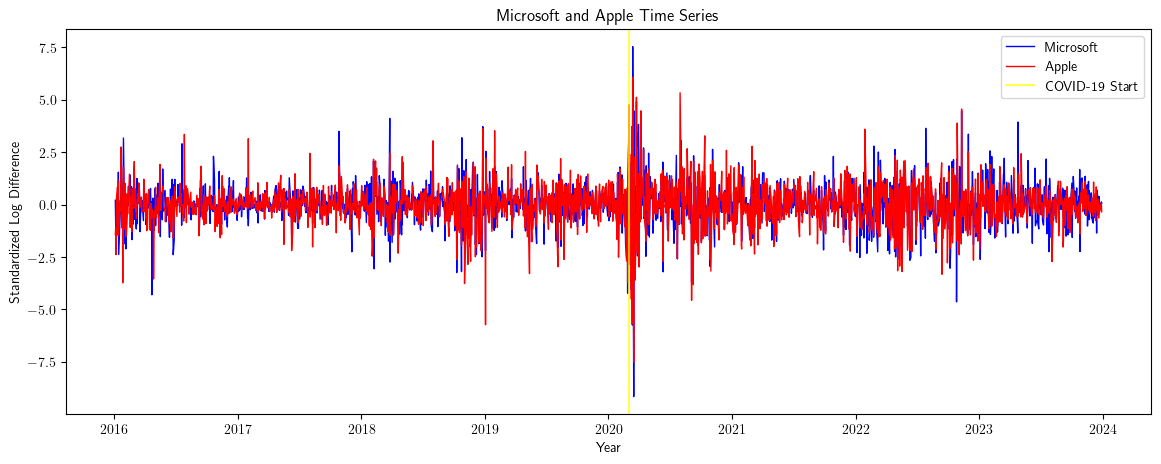

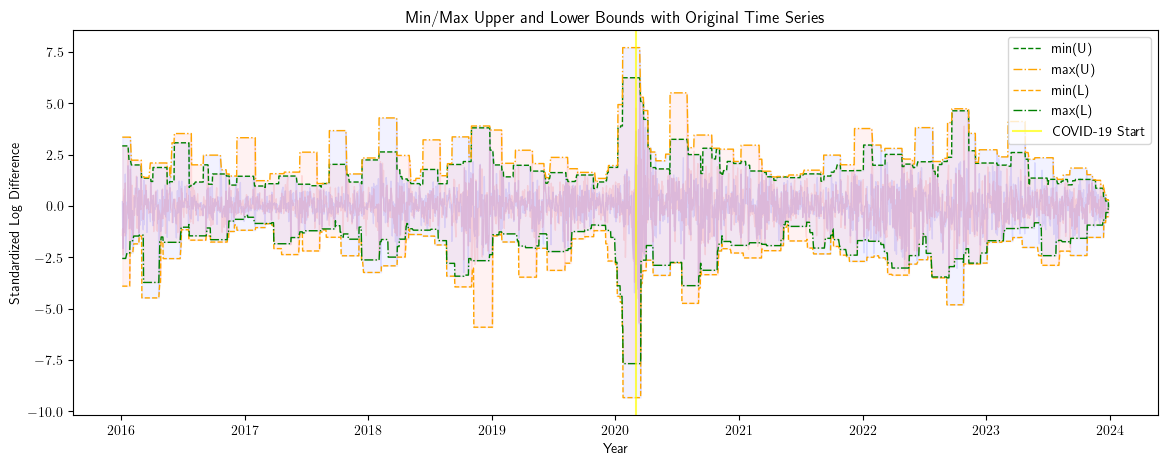

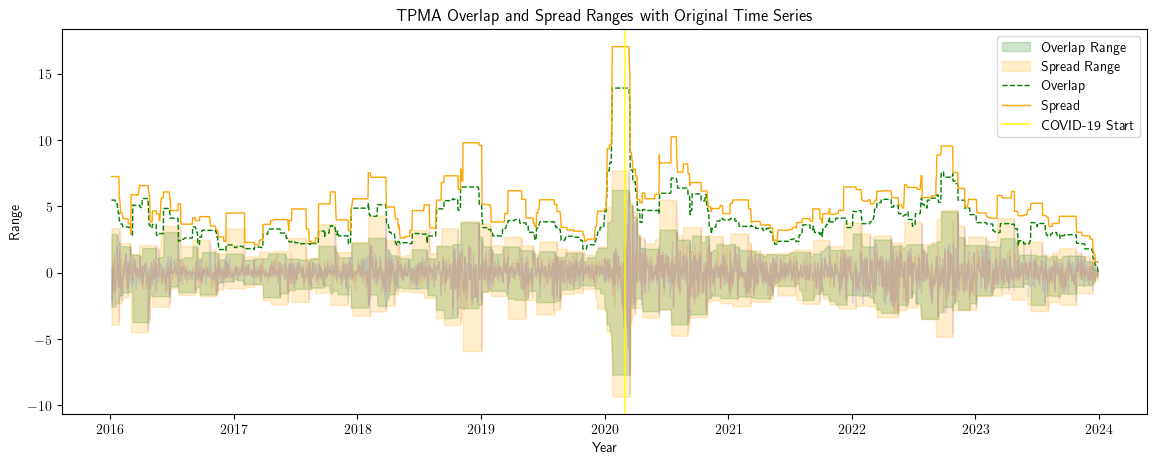

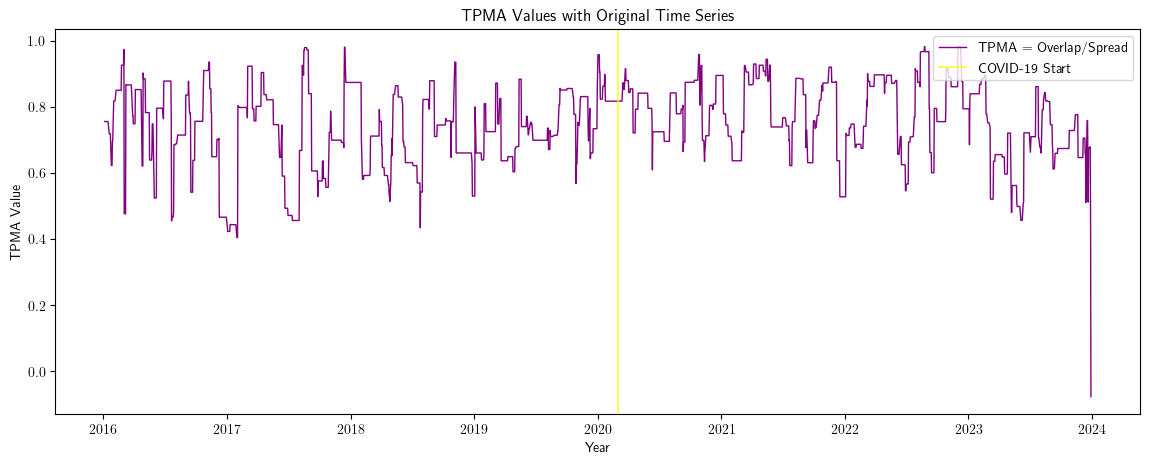

In [28]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# 데이터 크롤링 (최근 8년)
start_date = '2016-01-01'
end_date = '2024-01-01'
microsoft = yf.download('MSFT', start=start_date, end=end_date)
apple = yf.download('AAPL', start=start_date, end=end_date)

# 로그 변환 및 차분
log_microsoft = np.log(microsoft['Close'])
log_apple = np.log(apple['Close'])
diff_log_microsoft = log_microsoft.diff().dropna()
diff_log_apple = log_apple.diff().dropna()

# 표준화 함수
def standardize(series):
    return (series - series.mean()) / series.std()

# 차분 데이터 표준화
std_diff_log_microsoft = standardize(diff_log_microsoft)
std_diff_log_apple = standardize(diff_log_apple)

# 두꺼운펜변환 함수 (사각펜)
def thick_pen_transform(X, tau, gamma=0.01):
    n = len(X)
    U_tau = np.zeros(n)
    L_tau = np.zeros(n)
    
    for t in range(n - tau):
        U_tau[t] = np.max(X[t:t+tau+1]) + gamma * (tau / 2)
        L_tau[t] = np.min(X[t:t+tau+1]) - gamma * (tau / 2)
    
    # 경계 케이스 처리
    for t in range(n - tau, n):
        U_tau[t] = np.max(X[t:n]) + gamma * (tau / 2)
        L_tau[t] = np.min(X[t:n]) - gamma * (tau / 2)
    
    return L_tau, U_tau

tau = 35  # 두께 파라미터 설정
X = std_diff_log_microsoft.values
Y = std_diff_log_apple.values
dates = diff_log_microsoft.index

X_L_tau, X_U_tau = thick_pen_transform(X, tau)
Y_L_tau, Y_U_tau = thick_pen_transform(Y, tau)

# 코로나 시작 지점 설정
covid_start = '2020-03-01'
covid_start_idx = np.where(dates >= covid_start)[0][0]

# Upper와 Lower 각각 시각화 함수
def plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, X, label='Microsoft', color='blue', linewidth=1)
    plt.plot(dates, Y, label='Apple', color='red', linewidth=1)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='yellow', alpha=0.7, label='COVID-19 Start')

    plt.legend(loc='upper right')
    plt.title('Microsoft and Apple Time Series')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# min(U,U), max(U,U), min(L,L), max(L,L) 시각화 함수
def plot_min_max_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, X, color='blue', linewidth=1, alpha=0.1)
    plt.plot(dates, Y, color='red', linewidth=1, alpha=0.1)
    
    min_U = np.minimum(X_U_tau, Y_U_tau)
    max_U = np.maximum(X_U_tau, Y_U_tau)
    min_L = np.minimum(X_L_tau, Y_L_tau)
    max_L = np.maximum(X_L_tau, Y_L_tau)
    
    # 오버랩되는 부분을 음영 처리
    plt.fill_between(dates, X_L_tau, X_U_tau, color='blue', alpha=0.05)
    plt.fill_between(dates, Y_L_tau, Y_U_tau, color='red', alpha=0.05)
    
    plt.plot(dates, min_U, color='green', linestyle='--', linewidth=1, label='min(U)')
    plt.plot(dates, max_U, color='orange', linestyle='-.', linewidth=1, label='max(U)')
    plt.plot(dates, min_L, color='orange', linestyle='--', linewidth=1, label='min(L)')
    plt.plot(dates, max_L, color='green', linestyle='-.', linewidth=1, label='max(L)')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='yellow', alpha=0.7, label='COVID-19 Start')

    plt.legend(loc='upper right')
    plt.title('Min/Max Upper and Lower Bounds with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_min_max_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# TPMA의 분자와 분모 각각 시각화 함수
def plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    
    overlap_range = [min(X_U_tau[t], Y_U_tau[t]) - max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    spread_range = [max(X_U_tau[t], Y_U_tau[t]) - min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    
    plt.plot(dates, X, color='blue', linewidth=1, alpha=0.1)
    plt.plot(dates, Y, color='red', linewidth=1, alpha=0.1)
    
    # 분자와 분모에 해당하는 음영 추가
    plt.fill_between(dates, [max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))], [min(X_U_tau[t], Y_U_tau[t]) for t in range(len(X))], color='green', alpha=0.2, label='Overlap Range')
    plt.fill_between(dates, [min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))], [max(X_U_tau[t], Y_U_tau[t]) for t in range(len(X))], color='orange', alpha=0.2, label='Spread Range')
    
    plt.plot(dates, overlap_range, color='green', linestyle='--', linewidth=1, label='Overlap')
    plt.plot(dates, spread_range, color='orange', linestyle='-', linewidth=1, label='Spread')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='yellow', alpha=0.7, label='COVID-19 Start')

    plt.legend(loc='upper right')
    plt.title('TPMA Overlap and Spread Ranges with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('Range')
    plt.show()

# 시각화
plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# 두꺼운펜 변환 상관계수 계산 함수
def rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau):
    rho_tau_t = np.zeros(len(X))
    
    for t in range(len(X)):
        min_U = min(X_U_tau[t], Y_U_tau[t])
        max_L = max(X_L_tau[t], Y_L_tau[t])
        max_U = max(X_U_tau[t], Y_U_tau[t])
        min_L = min(X_L_tau[t], Y_L_tau[t])
        
        rho_tau_t[t] = (min_U - max_L) / (max_U - min_L)
    
    return rho_tau_t

# TPMA 계산
rho_values = rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau)

# TPMA 값 시각화 함수
def plot_tpma_values_with_series(rho_values, dates):
    plt.figure(figsize=(14, 5))
    
    plt.plot(dates, rho_values, label='TPMA = Overlap/Spread', color='purple', linewidth=1)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='yellow', alpha=0.7, label='COVID-19 Start')

    plt.legend(loc='upper right')
    plt.title('TPMA Values with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('TPMA Value')
    plt.show()

# 시각화
plot_tpma_values_with_series(rho_values, dates)